<a href="https://colab.research.google.com/github/jhasa93/Course/blob/master/007TargetedTranscytosisNoApical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This model consider transcytosis and seperate storage to lysosomes.
It uses experimental data from Max's and Rachel's paper for training and kinetic rate estimation.



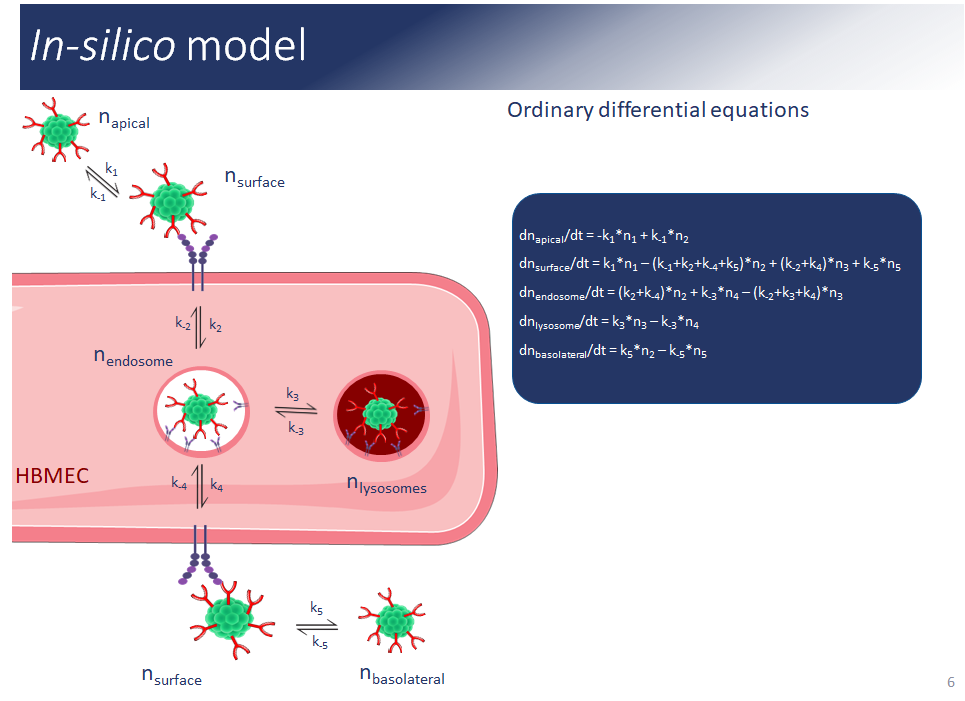

In [0]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation
from tensorflow.python.keras.layers.core import Dense
from tensorflow.python.keras.optimizers import SGD
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np
import pandas as pd

In [2]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 003 Data.xlsx to 003 Data (1).xlsx
User uploaded file "003 Data.xlsx" with length 45548 bytes


Analytical solution for random kinetic constants and experimental values.

**Equations need to be updated to fit the model.**

In [3]:
data_experimental = pd.read_excel(fn,sheet_name='50%R6.5')
t_experimental,n_experimental = data_experimental['tau'].dropna(0,how='any') , data_experimental.loc[:,['n_surface','n_lysosomes','n_endosome','n_basolateral']].dropna(0,how='any')
print(t_experimental,'\n',n_experimental)

0    0.000000
1    0.016667
2    0.083333
3    0.150000
4    0.250000
5    0.783333
6    0.983333
Name: tau, dtype: float64 
    n_surface  n_lysosomes  n_endosome  n_basolateral
0   0.495075     0.103888    0.401036       0.000000
1   0.195790     0.263113    0.427661       0.113435
2   0.058255     0.352329    0.367790       0.221626
3   0.016662     0.411572    0.189641       0.382125
4   0.005969     0.395366    0.119051       0.479614
5   0.000014     0.323494    0.106976       0.569517
6   0.000013     0.292334    0.096672       0.610981


In [0]:
def AnalyticalSolution(k,t_analytical,x0):
  
  def dndt(t,x):
    k2,km2,k3,km3,k4,km4,k5,km5 = k
    nsurface,nlysosome,nendosome,nbasolateral = x
    n2,n3,n4,n5 =nsurface,nendosome,nlysosome,nbasolateral

    dnsurface_dt 	= - (k2+km4+k5)*n2 + (km2+k4)*n3 + km5*n5
    dnendosome_dt	= (k2+km4)*n2 + km3*n4 - (km2+k3+k4)*n3 
    dnlysosome_dt = k3*n3 - km3*n4
    dnbasolateral_dt 	= k5*n2 - km5*n5
    return [dnsurface_dt,dnlysosome_dt,dnendosome_dt,dnbasolateral_dt]

  t_span = (t_analytical[0],t_analytical[-1])
  sol = solve_ivp(dndt,t_span,x0,dense_output=True)
  n_analytical = sol.sol(t_analytical)
  n_analytical = n_analytical.T
  return n_analytical

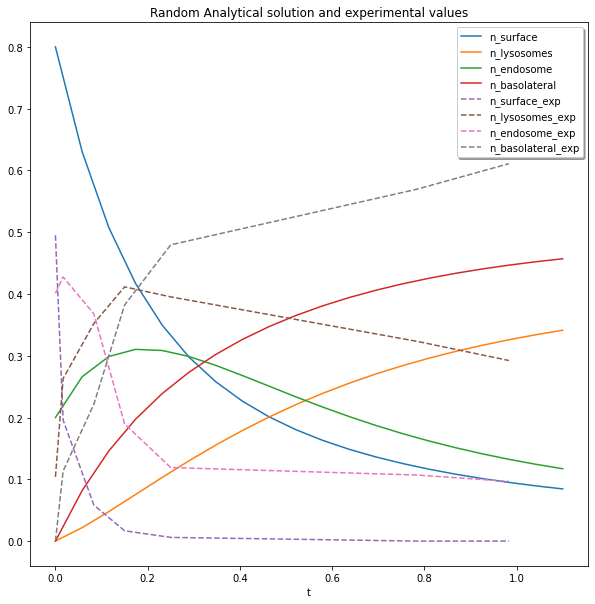

In [5]:
k_random = np.array([13,8,8,1,2,1,10,1])/5
x0 = [0.8,0,0.2,0.0] # napical,nsurface,nlysosome,nendosome,nbasolateral at time = 0
t_span = [0,1.1]
t_analytical = np.linspace(t_span[0], t_span[1], 20)
n_analytical = AnalyticalSolution(k_random,t_analytical,x0)


legend = n_experimental.columns

plt.figure(figsize=(10,10))
plt.plot(t_analytical, n_analytical,'-',t_experimental, n_experimental,'--')
plt.plot()
plt.xlabel('t')
legend1 = legend.append(legend+'_exp')
plt.legend(legend1, shadow=True)
plt.title('Random Analytical solution and experimental values')
plt.show()

In [6]:
model = Sequential([
                    Dense(8,input_dim=1,activation='sigmoid'),
                    Dense(4,activation='sigmoid')])
model.summary()
from tensorflow.keras.optimizers import Adam
model.compile(Adam(lr=0.002), loss='mean_squared_error',metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 16        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(t_experimental,n_experimental,epochs=4000,batch_size=1,verbose=0)

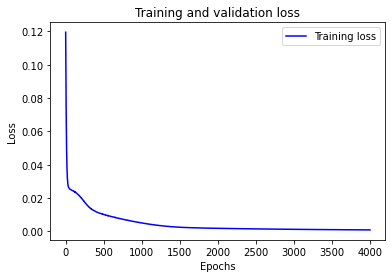

In [8]:
history_dict = history.history
acc=history_dict['accuracy']
loss_values = history_dict['loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss_values, 'b-', label='Training loss')
#plt.plot(epochs, acc, 'b-', label='Accuracy')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

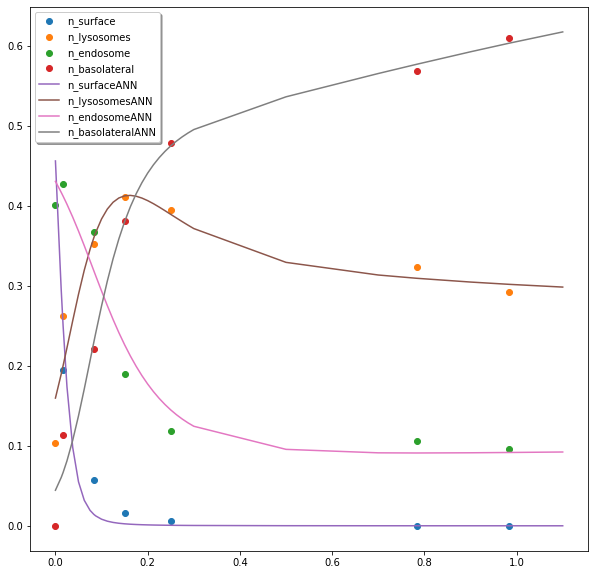

In [9]:
t1 = np.linspace(0.00001,0.3,25)
t2 = np.linspace(0.30001,1.1,5)
t = np.append(t1,t2)
t = np.append(t,t_experimental)
t = np.sort(t)
n_predicted=model.predict(t)
plt.figure(figsize=(10,10))
plt.plot(t_experimental[:],n_experimental[:],'o',t,n_predicted)
legend2 = legend.append(legend+'ANN')
plt.legend(legend2, shadow=True)
#for layer in model.layers: print(layer.get_weights())
#print(len(n_predicted[0,:]))

In [0]:
def GetDerivationFromNN(model):
  hidden_layer_weights = model.layers[0].get_weights()[0]
  hidden_layer_biases  = model.layers[0].get_weights()[1]
  output_layer_weights = model.layers[1].get_weights()[0]
  output_layer_biases  = model.layers[1].get_weights()[1]

  x=np.zeros([len(t),len(hidden_layer_weights[0,:])])
  for ti in range(len(t)):
    x[ti]=hidden_layer_weights*t[ti] + hidden_layer_biases

  y=np.zeros([len(t),len(x[0,:])])
  for ti in range(len(t)):
    y[ti]=1/(1+np.exp(-x[ti]))

  z=np.zeros([len(t),len(output_layer_weights[0,:])])
  for ti in range(len(t)):
    suma=0
    for j in range(len(output_layer_weights[0,:])):
      suma=sum(y[ti]*output_layer_weights[:,j])
      #print(j,y[t],output_layer_weights[:,j],suma)
      z[ti,j]=suma+output_layer_biases[j]
      #print(z,output_layer_biases)
  #print(n_predicted-1/(1+np.exp(-z))) #should be almost equal

  dndt_predicted=np.zeros([len(t),len(z[0,:])])
  for ti in range(len(t)):
    suma=0
    for j in range(len(output_layer_weights[0,:])):
      suma=sum(sum(output_layer_weights[:,j]*np.exp(-x[ti])*hidden_layer_weights/((1+np.exp(-x[ti]))**2)))
      #print(t,i,suma)
      dndt_predicted[ti,j]=(np.exp(-z[ti,j])/(1+np.exp(-z[ti,j])**2))*suma
  #print(dndt_predicted,'\n',n_predicted)
  return dndt_predicted

In [0]:
def Get_k_predicted(dndt_predicted,n_predicted,k):
  
  dnsurface_dt_prd=dndt_predicted[:,0]
  dnendosome_dt_prd=dndt_predicted[:,2]
  dnlysosome_dt_prd=dndt_predicted[:,1]
  dnbasolateral_dt_prd=dndt_predicted[:,3]

  
  nsurface_prd = n_predicted[:,0]
  nendosome_prd=n_predicted[:,2]
  nlysosome_prd=n_predicted[:,1]
  nbasolateral_prd = n_predicted[:,3]
  x = n_predicted[:,0:3]

  def f_prd(k,tau):
    k2,km2,k3,km3,k4,km4,k5,km5 = k
    n2,n3,n4,n5 = nsurface_prd,nendosome_prd,nlysosome_prd,nbasolateral_prd
    suma=0

    for ti in range(len(tau)):
      e_surface = - dnsurface_dt_prd[ti] - (k2+km4+k5)*n2[ti] + (km2+k4)*n3[ti] + km5*n5[ti]
      e_endosome = - dnendosome_dt_prd[ti] + (k2+km4)*n2[ti] + km3*n4[ti] - (km2+k3+k4)*n3[ti] 
      e_lysosome = - dnlysosome_dt_prd[ti] + k3*n3[ti] - km3*n4[ti] 
      e_basolateral = - dnbasolateral_dt_prd[ti] + k5*n2[ti] - km5*n5[ti]
      penalty =  min(k2,0) + min(km2,0) + min(k3,0) + min(km3,0) + min(k4,0) + min(km4,0) + min(k5,0) + min(km5,0)
      suma = suma + e_surface**2 + e_endosome**2 + e_lysosome**2 + e_basolateral**2 + penalty**2
    return suma

  from scipy.optimize import minimize
  k0=[1,1,1,1,1,1,1,1]
  res = minimize(f_prd, k0,args=(t), method='BFGS',options={'gtol': 1e-4,'disp': True})
  k_prd = res['x']
  print('k_prd=',k_prd,'\n','k=',k,'\n','error in %',100*((k-k_prd)/k))
  return k_prd

In [12]:
dndt_predicted = GetDerivationFromNN(model)
k_prd = Get_k_predicted(dndt_predicted,n_predicted,k_random)

Optimization terminated successfully.
         Current function value: 657.172702
         Iterations: 26
         Function evaluations: 340
         Gradient evaluations: 34
k_prd= [14.19704337  0.33502157 19.58371166  7.7770759   0.33502157 14.19704337
 19.4962325  -0.42640749] 
 k= [2.6 1.6 1.6 0.2 0.4 0.2 2.  0.2] 
 error in % [ -446.04012944    79.06115165 -1123.98197896 -3788.53794865
    16.24460659 -6998.52168272  -874.8116248    313.20374624]


In [0]:
dnsurface_dt = dndt_predicted[:,0]
dnendosome_dt = dndt_predicted[:,2]
dnlysosome_dt = dndt_predicted[:,1]
dnbasolateral_dt = dndt_predicted[:,3]

nsurface = n_experimental.iloc[:,0]
nendosome = n_experimental.iloc[:,2]
nlysosome = n_experimental.iloc[:,1]
nbasolateral = n_experimental.iloc[:,3]



def f(k,tau):
  k2,km2,k3,km3,k4,km4,k5,km5 = k
  n2,n3,n4,n5 = nsurface,nendosome,nlysosome,nbasolateral
  suma=0
  for ti in range(len(tau)):
    tj = np.where(t==tau[ti])[0]
    e_surface = - dnsurface_dt[tj] - (k2+km4+k5)*n2[ti] + (km2+k4)*n3[ti] + km5*n5[ti]
    e_endosome = - dnendosome_dt[tj] + (k2+km4)*n2[ti] + km3*n4[ti] - (km2+k3+k4)*n3[ti] 
    e_lysosome = - dnlysosome_dt[tj] + k3*n3[ti] - km3*n4[ti] 
    e_basolateral = - dnbasolateral_dt[tj] + k5*n2[ti] - km5*n5[ti]
    penalty =  min(k2,0) + min(km2,0) + min(k3,0) + min(km3,0) + min(k4,0) + min(km4,0) + min(k5,0) + min(km5,0)
    suma = suma +  e_surface**2 +e_endosome**2 + e_lysosome**2 + e_basolateral**2 + penalty**2
  return suma

In [14]:
from scipy.optimize import minimize
k0=[1,1,1,1,1,1,1,1]
res = minimize(f, k_prd,args=(t_experimental),method='BFGS',options={'gtol': 1e-4,'disp': True})
k_opt = res['x']
print('k_opt=',k_opt)

         Current function value: 271.225892
         Iterations: 4
         Function evaluations: 1152
         Gradient evaluations: 114
k_opt= [ 1.30985465e+01 -6.58402003e-10  2.02987532e+01  7.25893621e+00
 -6.58435532e-10  1.30985465e+01  1.83776819e+01 -2.50739572e-01]


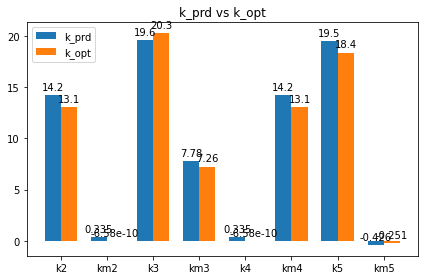

In [15]:
k_labels = ['k2','km2','k3','km3','k4','km4','k5','km5']

x = np.arange(len(k_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, k_prd, width, label='k_prd')
rects2 = ax.bar(x + width/2, k_opt, width, label='k_opt')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('')
ax.set_title('k_prd vs k_opt')
ax.set_xticks(x)
ax.set_xticklabels(k_labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3g}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

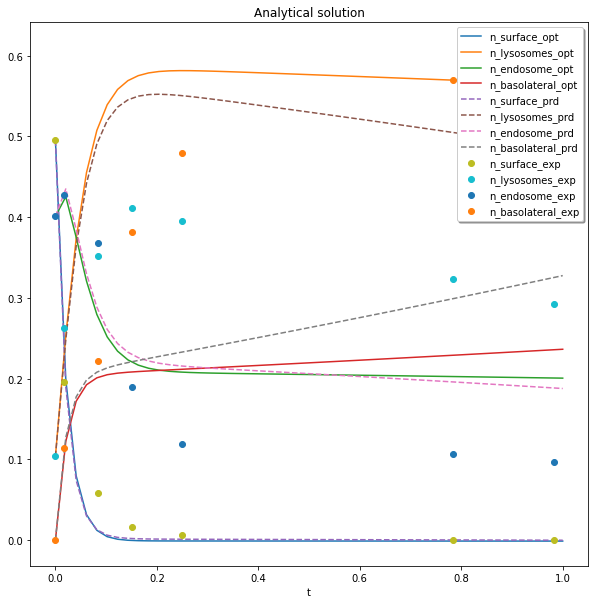

In [16]:
x0_exp = n_experimental.loc[0,:] # napical,nsufrace,nlysosome,nendosome,nbasolateral at time = 0
t_final = np.linspace(0,1,50)
n_analytical_kopt = AnalyticalSolution(k_opt,t_final,x0_exp)
n_analytical_kprd = AnalyticalSolution(k_prd,t_final,x0_exp)

legend_exp = legend+'_exp'
legend_k_prd = legend + '_prd'
legend_k_opt = legend + '_opt'

legend_k_opt = legend_k_opt.append(legend_k_prd)
legend_k_opt = legend_k_opt.append(legend_exp)

plt.figure(figsize=(10,10))
plt.plot(t_final, n_analytical_kopt,'-')
plt.plot(t_final, n_analytical_kprd,'--')
plt.plot(t_experimental, n_experimental,'o')
plt.xlabel('t')

plt.legend(legend_k_opt, shadow=True)
plt.title('Analytical solution')
plt.show()